Loading Labels...
Loaded 10 TXT files from Database_Realtime/IMU
Loading Images...
Loaded 10 images from Database_Realtime/Vision/Webcam
Image shape: (10, 480, 640, 3)
Labels: 10
Augmenting images...


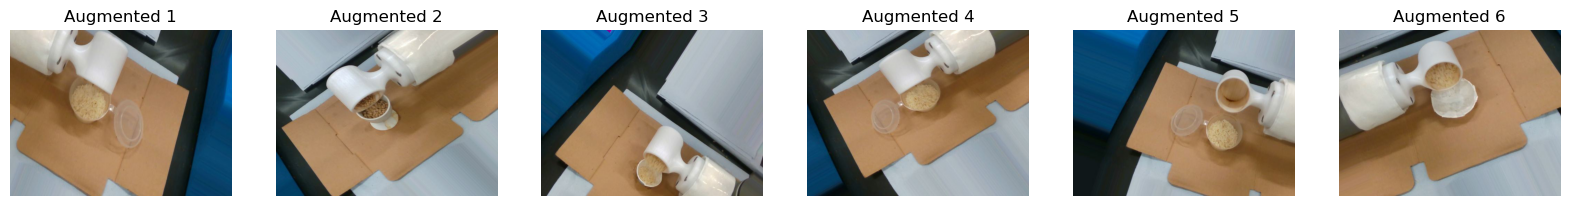

In [ ]:
# Task 1: Data Preparation and Preprocessing (Exploratory Data Analysis and Augmentation)

from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import random
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

#paths ...
BASE = "Database_Realtime"
IMU = os.path.join(BASE, "IMU")
VISION = os.path.join(BASE, "Vision/Webcam")

#labels...
def load_labels(base_dir, num_samples=10):
    txt_data = {}
    label_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".txt"):
                label_files.append(os.path.join(root, file))
    
    selected_label_files = random.sample(label_files, min(num_samples, len(label_files)))
    
    for file_path in selected_label_files:
        try:
            with open(file_path, 'r') as f:
                txt_data[file_path] = f.read()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    print(f"Loaded {len(txt_data)} TXT files from {base_dir}")
    return txt_data

#images...
def load_images(base_dir, num_samples=10):
    images = []
    filenames = []
    image_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))
    
    selected_image_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    for file_path in selected_image_files:
        try:
            image = Image.open(file_path).convert('RGB')
            images.append(np.array(image))
            filenames.append(file_path)
        except UnidentifiedImageError as e:
            print(f"Error loading image {file_path}: {e}")
    
    print(f"Loaded {len(images)} images from {base_dir}")
    return np.array(images), filenames


#call funcs...
print("Loading Labels...")
txt_files = load_labels(IMU, num_samples=10)

print("Loading Images...")
images, image_paths = load_images(VISION, num_samples=10)

print("Image shape:", images.shape)
print("Labels:", len(txt_files))


print("Augmenting images...")

#augmenting.....
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#output directory...
augmented_dir = 'augmented_images'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)



sample_image = images[0].reshape((1, *images[0].shape))  
i = 0
for batch in datagen.flow(sample_image, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='jpeg'):
    i += 1
    if i > 5:  
        break

#display images...
augmented_images = os.listdir(augmented_dir)
fig, axes = plt.subplots(1, 6, figsize=(20, 20))

for i, img_name in enumerate(augmented_images[:6]):
    img = Image.open(os.path.join(augmented_dir, img_name))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Augmented {i+1}")
plt.show()




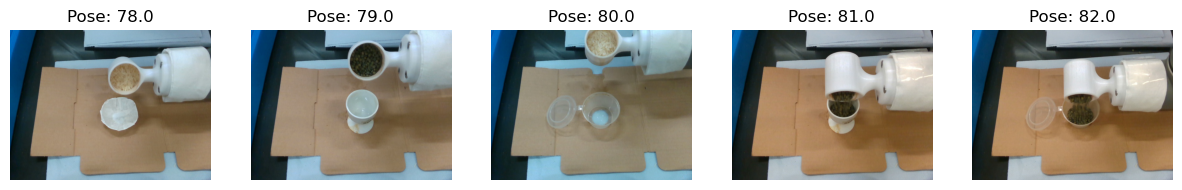

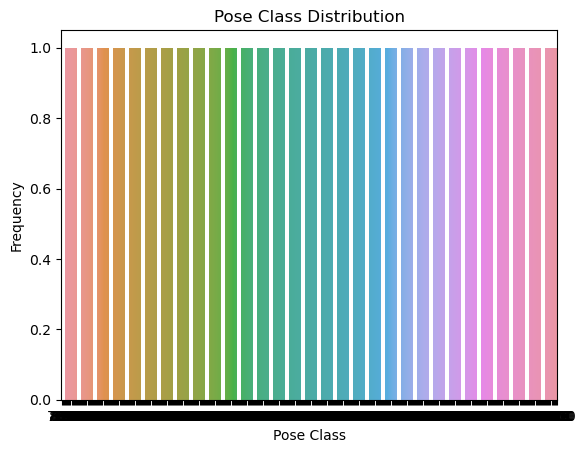

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#parse labels from txt....
def parse_labels(txt_data):
    labels = []
    for file_path, data in txt_data.items():
        lines = data.splitlines()
        for line in lines:
            values = line.split()
            if len(values) >= 4:  
                pose = int(values[0]) 
                depth = float(values[1])  
                pitch = float(values[2])  
                roll = float(values[3])  
                labels.append([pose, depth, pitch, roll])
    return np.array(labels)

#parsing....
y_labels = parse_labels(txt_files)

# visualizing...
def visualize_samples(X, y, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[i].imshow(X[i])
        axes[i].axis('off')
        axes[i].set_title(f"Pose: {y[i][0]}")  # Assuming pose is the first label
    
    plt.show()


visualize_samples(images, y_labels)

#analysing....
pose_counts = y_labels[:, 0] 
sns.countplot(x=pose_counts)
plt.title('Pose Class Distribution')
plt.xlabel('Pose Class')
plt.ylabel('Frequency')
plt.show()




In [ ]:
#Data Augmentation (Optional: 2 Bonus Points)

#data augmentation...
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#example... [on 1 img]
# augmented_image = datagen.random_transform(images[0])
# plt.imshow(augmented_image)
# plt.title("Augmented Image Example")
# plt.axis('off')
# plt.show()



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

#numpy array conversion...
X_images = np.array(images)  

#y_labels match the number of imgs?...
y_pose = y_labels[:, 0] 
depth_labels = y_labels[:, 1] 

#pose + depth labels have same length as the no of images?...
y_pose = y_pose[:X_images.shape[0]]  
depth_labels = depth_labels[:X_images.shape[0]]  

#normalise....
X_images = X_images / 255.0

#standardise...
depth_labels = (depth_labels - np.mean(depth_labels)) / np.std(depth_labels)

#stack...
y_labels = np.stack((y_pose, depth_labels), axis=1)

#split data.... 
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)





Training set shape: (6, 480, 640, 3)
Validation set shape: (2, 480, 640, 3)
Test set shape: (2, 480, 640, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

#CNN modelpose classification...
def create_cnn_model(input_shape, num_classes=5):
    model = Sequential()


    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())  
    model.add(MaxPooling2D((2, 2)))


    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))


    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))


    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) 

    model.add(Dense(num_classes, activation='softmax'))  
    
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#summarise model....
model = create_cnn_model(X_train.shape[1:])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 478, 638, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 239, 319, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 237, 317, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

if len(X_train.shape) == 3:
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]


print("Unique labels in y_train:", np.unique(y_train))
print("y_train dtype:", y_train.dtype)

print("Model input shape:", model.input_shape)
print("X_train shape:", X_train.shape)


import numpy as np


num_classes = 5

#bins for labels to categorise...
bins = np.linspace(np.min(y_train), np.max(y_train), num_classes + 1)

#digitalising....
y_train_classes = np.digitize(y_train, bins) - 1
y_val_classes = np.digitize(y_val, bins) - 1
y_test_classes = np.digitize(y_test, bins) - 1

#converting to int....
y_train_classes = y_train_classes.astype('int')
y_val_classes = y_val_classes.astype('int')
y_test_classes = y_test_classes.astype('int')


print("Unique labels in y_train_classes:", np.unique(y_train_classes))


X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


from keras.preprocessing.image import ImageDataGenerator

#augmentation...
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

#fit...
datagen.fit(X_train)



X_train shape: (6, 480, 640, 3)
X_val shape: (2, 480, 640, 3)
X_test shape: (2, 480, 640, 3)
Unique labels in y_train: [-0.84629356 -0.58215699  0.21025271  0.49199838  0.86178957  1.54854464
 80.         81.         83.         84.         85.         87.        ]
y_train dtype: float64
Model input shape: (None, 480, 640, 3)
X_train shape: (6, 480, 640, 3)
Unique labels in y_train_classes: [0 4 5]


In [ ]:
#model 2....
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_lenet(input_shape, num_classes=5):
    model = Sequential([
        Conv2D(6, (5, 5), activation='tanh', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (5, 5), activation='tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(120, activation='tanh'),
        Dropout(0.5),  
        Dense(84, activation='tanh'),
        Dropout(0.5), 
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


model = create_lenet(X_train.shape[1:])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 476, 636, 6)       456       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 238, 318, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 234, 314, 16)      2416      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 117, 157, 16)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 293904)            0         
                                                                 
 dense_2 (Dense)             (None, 120)              

In [ ]:

bins = np.linspace(np.min(y_train), np.max(y_train), num_classes + 1)

#digitise...
y_train_classes = np.digitize(y_train, bins) - 1
y_val_classes = np.digitize(y_val, bins) - 1
y_test_classes = np.digitize(y_test, bins) - 1

#convert to int...
y_train_classes = y_train_classes.astype('int')
y_val_classes = y_val_classes.astype('int')
y_test_classes = y_test_classes.astype('int')


print("Unique labels in y_train_classes:", np.unique(y_train_classes))



Unique labels in y_train_classes: [0 4 5]


In [ ]:
#model 3....
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

def create_resnet(input_shape, num_classes=5):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  
    predictions = Dense(num_classes, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


model = create_resnet(X_train.shape[1:])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 486, 646, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 240, 320, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 240, 320, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
#createres-net ...
model_resnet = create_resnet(X_train.shape[1:])

#training...
history_resnet = model_resnet.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1
)

#evaluating...
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy (ResNet): {test_acc_resnet}')


Epoch 1/20


ValueError: in user code:

    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 5) are incompatible


In [ ]:
#plotting models data...
def plot_history(history, model_name):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

# # Plot for CNN
# plot_history(history_cnn, "CNN")

# # Plot for LeNet
# plot_history(history_lenet, "LeNet")

# # Plot for ResNet
# plot_history(history_resnet, "ResNet")



In [14]:
# print(f'Test accuracy (CNN): {test_acc}')
# print(f'Test accuracy (LeNet): {test_acc_lenet}')
# print(f'Test accuracy (ResNet): {test_acc_resnet}')
# # Save models
# model.save('cnn_model.h5')
# model_lenet.save('lenet_model.h5')
# model_resnet.save('resnet_model.h5')



In [ ]:
#normalise...
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

#labels = continous?...
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")


y_train shape: (6, 2), dtype: float64


In [ ]:
#regressoin
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_mlp(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  
    return model


In [ ]:
#training....
input_shape = (X_train.shape[1],) 
mlp_model = create_mlp(input_shape)


history_mlp = mlp_model.fit(
    X_train.reshape(X_train.shape[0], -1), y_train,  
    epochs=20,
    batch_size=32,
    validation_data=(X_val.reshape(X_val.shape[0], -1), y_val),
    verbose=1
)

#evaluating...
test_loss_mlp, test_mae_mlp = mlp_model.evaluate(X_test.reshape(X_test.shape[0], -1), y_test, verbose=2)
print(f"Test MAE (MLP): {test_mae_mlp}")


Epoch 1/20


ValueError: in user code:

    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_23" is incompatible with the layer: expected shape=(None, 480), found shape=(None, 921600)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1)) 
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [ ]:
#rtaining...
input_shape_cnn = X_train.shape[1:]  
cnn_model = create_cnn(input_shape_cnn)

#fitting...
history_cnn = cnn_model.fit(
    X_train, y_train, 
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

#evaluating...
test_loss_cnn, test_mae_cnn = cnn_model.evaluate(X_test, y_test, verbose=2)
print(f"Test MAE (CNN): {test_mae_cnn}")


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 2619.1943 - mae: 36.5330 - val_loss: 2337.6409 - val_mae: 34.9344
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 2574.9543 - mae: 36.2162 - val_loss: 2119.4438 - val_mae: 34.9344
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2341.8416 - mae: 36.0214 - val_loss: 1742.5166 - val_mae: 34.9344
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 1901.2617 - mae: 36.0214 - val_loss: 1321.2090 - val_mae: 34.9344
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 1509.6128 - mae: 36.0214 - val_loss: 1342.0049 - val_mae: 34.9344
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 1400.5834 - mae: 36.0214 - val_loss: 1878.5687 - val_mae: 34.9344
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 2063.3115 - mae: 36.0214 - val_loss: 1521.0215 - val_mae: 34.9344
Epoch 8/20
1/1 [==============================] - 2s 2s

: 

In [ ]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

def create_resnet(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1)(x) 
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [ ]:
# training...
input_shape_resnet = X_train.shape[1:] 
resnet_model = create_resnet(input_shape_resnet)

#fitting....
history_resnet = resnet_model.fit(
    X_train, y_train, 
    epochs=20,
    batch_size=16, 
    validation_data=(X_val, y_val),
    verbose=1
)

#evaluating....
test_loss_resnet, test_mae_resnet = resnet_model.evaluate(X_test, y_test, verbose=2)
print(f"Test MAE (ResNet): {test_mae_resnet}")


NameError: name 'X_train' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

#RMSE...
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

#after training...
y_pred = model.predict(X_test)
rmse = calculate_rmse(y_test, y_pred)
print(f"RMSE: {rmse}")


1/1 [==============================] - 1s 1s/step


ValueError: y_true and y_pred have different number of output (2!=5)